# Imports

In [1]:
import os
import time 
import json

import gtsam

import pandas as pd
import numpy as np
from scipy.optimize import linear_sum_assignment
from scipy.spatial import distance
import matplotlib.pyplot as plt

from nuscenes.can_bus.can_bus_api import NuScenesCanBus
from nuscenes.eval.common.utils import quaternion_yaw
from nuscenes.map_expansion.map_api import NuScenesMap
from nuscenes.nuscenes import NuScenes
import nuscenes.utils.splits as nuscenes_splits

import rosbag2_py
from rosidl_runtime_py.utilities import get_message
from rclpy.serialization import deserialize_message

In [2]:
# Declare parameters
nuscenes_dir = '/home/jd/nuScenes/data'
mcap_dir = '/home/jd/nuScenes/data/mcap'
results_dir = '/home/jd/tracking_ws/src/ros_tracking/results'
# dataset_name: 'v1.0-mini'
split_name = 'mini_train'
lidar_detector = 'megvii'
ann_topic = '/annotations'
det_topic = '/detections'

# Weights?
asgn_thresh = 10.0
euc_thresh = 2.0

# Initial spatial covariance
# pos_sigma = np.array([1, 1, 1])
# pos_cov = np.diag(pos_sigma**2)
# pos_cov_inv = np.linalg.inv(pos_cov)
# print(pos_cov)
# print(pos_cov_inv)

In [3]:
# Create ROS objects
reader = rosbag2_py.SequentialReader()

In [4]:
# Member variables
lidar_det_string = "-" + lidar_detector if lidar_detector else ""
match_cols = ['ann_px','ann_py','ann_pz','ann_yaw','ann_sx','ann_sy','ann_sz','ann_lbl',
              'det_px','det_py','det_pz','det_yaw','det_sx','det_sy','det_sz','det_lbl','det_conf']

unmatch_trk_cols = ['ann_px','ann_py','ann_pz','ann_sx','ann_sy','ann_sz','ann_lbl']
unmatch_det_cols = ['det_px','det_py','det_pz','det_sx','det_sy','det_sz','det_lbl','det_conf']


# Remap nuScenes class -> tracking class (See https://www.nuscenes.org/tracking/ classes)
track_class_map = {"animal": "void_ignore",
                      "human.pedestrian.personal_mobility": "void_ignore",
                     "human.pedestrian.stroller": "void_ignore",
                     "human.pedestrian.wheelchair": "void_ignore",
                     "movable_object.barrier": "void_ignore",
                     "movable_object.debris": "void_ignore",
                     "movable_object.pushable_pullable": "void_ignore",
                     "movable_object.trafficcone": "void_ignore",
                     "static_object.bicycle_rack": "void_ignore",
                     "vehicle.emergency.ambulance": "void_ignore",
                     "vehicle.emergency.police": "void_ignore",
                     "vehicle.construction": "void_ignore",
                     "vehicle.bicycle": "bicycle",
                     "vehicle.bus.bendy": "bus",
                     "vehicle.bus.rigid": "bus",
                     "vehicle.car": "car",
                     "vehicle.motorcycle": "motorcycle",
                     "human.pedestrian.adult": "pedestrian",
                     "human.pedestrian.child": "pedestrian",
                     "human.pedestrian.construction_worker": "pedestrian",
                     "human.pedestrian.police_officer": "pedestrian",
                     "vehicle.trailer": "trailer",
                     "vehicle.truck": "truck"}

det_class_map = {'barrier': 'void_ignore',
              'bicycle': 'bicycle',
              'bus': 'bus',
              'car': 'car',
              'construction_vehicle': 'void_ignore',
              'motorcycle': 'motorcycle',
              'pedestrian': 'pedestrian',
              'traffic_cone': 'void_ignore',
              'trailer': 'trailer',
              'truck': 'truck'}

# Compute matches & save

In [5]:
# Dataframes
raw_df = pd.DataFrame(columns=match_cols)
match_df = pd.DataFrame(columns=match_cols)
unmatched_det_df = pd.DataFrame(columns=unmatch_det_cols)
unmatched_trk_df = pd.DataFrame(columns=unmatch_trk_cols)

# COMPUTE MATCH

# Main loop - iterate through splits and mcaps
split = eval('nuscenes_splits.' + split_name)

for kk, scene in enumerate(split): # for scene in split
    print("Processing scene %s (%i / %i)" % (scene, kk, len(split)))
    print("%s/%s%s/%s%s_0.mcap \n" % (mcap_dir, scene, lidar_det_string, scene, lidar_det_string))

    # Load bag
    storage_options = rosbag2_py.StorageOptions(
        uri="%s/%s%s/%s%s_0.mcap" % (mcap_dir, scene, lidar_det_string, scene, lidar_det_string),
        storage_id='mcap')
    converter_options = rosbag2_py.ConverterOptions('', '')
    reader.open(storage_options, converter_options)
    
    # Deal with type names
    topic_types = reader.get_all_topics_and_types()

    def typename(topic_name):
        for topic_type in topic_types:
            if topic_type.name == topic_name:
                return topic_type.type
        raise ValueError(f"topic {topic_name} not in bag")
 
    got_ann = False
    got_det = False
    while reader.has_next():
        
        topic, data, timestamp = reader.read_next()

        if topic==ann_topic:
            # self.get_logger().info("Topic: %s" % (topic))                  

            ann_msg_type = get_message(typename(topic))
            ann_msg = deserialize_message(data, ann_msg_type)
            
            got_ann = True
        
        if topic==det_topic:
            # self.get_logger().info("Topic: %s" % (topic))                  

            det_msg_type = get_message(typename(topic))
            det_msg = deserialize_message(data, det_msg_type)
            
            got_det = True
            
        if got_ann and got_det:
           
            # Compute cost matrix
            n_dets = len(det_msg.entities)
            n_anns = len(ann_msg.entities)
            
            cost_matrix = np.zeros((n_dets,n_anns))
            for ii,det in enumerate(det_msg.entities):
                for jj,trk in enumerate(ann_msg.entities):
                    
                    cost = np.linalg.norm([det.cubes[0].pose.position.x - trk.cubes[0].pose.position.x,
                                           det.cubes[0].pose.position.y - trk.cubes[0].pose.position.y,
                                           det.cubes[0].pose.position.z - trk.cubes[0].pose.position.z])
                    
                    # print("det label raw: %s, mapped: %s" % (det.metadata[0].value, det_class_map[det.metadata[0].value]))
                    # print("ann label raw: %s, mapped: %s" % (trk.metadata[0].value, track_class_map[trk.metadata[0].value]))

                    if det_class_map[det.metadata[0].value] != track_class_map[trk.metadata[0].value]:
                        # print('class mismatch')
                        cost += 20
                    
                    cost_matrix[ii,jj] = cost

            
            # Solve cost matrix
            # TODO - can reuse assignment.py here
            det_asgn_idx, trk_asgn_idx = linear_sum_assignment(cost_matrix)
            det_asgn_idx, trk_asgn_idx = list(det_asgn_idx), list(trk_asgn_idx)
            
            # If cost above threshold, remove the match from assignment vector
            assert(len(det_asgn_idx) == len(trk_asgn_idx))
            ii = len(det_asgn_idx)
            while ii:
                idx = ii-1
                if cost_matrix[det_asgn_idx[idx],trk_asgn_idx[idx]] > euc_thresh:
                    del det_asgn_idx[idx], trk_asgn_idx[idx]       
                ii -=1
            assert(len(det_asgn_idx) == len(trk_asgn_idx))
            
            # Handle matches
            for det_idx, trk_idx in zip(det_asgn_idx, trk_asgn_idx):
                
                # match_cols = ['ann_px','ann_py','ann_pz','ann_sx','ann_sy','ann_sz','ann_lbl',
                # 'det_px','det_py','det_pz','det_sx','det_sy','det_sz','det_lbl','det_conf']
                data_df = pd.DataFrame([[ann_msg.entities[trk_idx].cubes[0].pose.position.x, 
                                         ann_msg.entities[trk_idx].cubes[0].pose.position.y,
                                         ann_msg.entities[trk_idx].cubes[0].pose.position.z,
                                         np.arctan2(2.0*(ann_msg.entities[trk_idx].cubes[0].pose.orientation.w*ann_msg.entities[trk_idx].cubes[0].pose.orientation.z), 1 - 2*ann_msg.entities[trk_idx].cubes[0].pose.orientation.z**2),                                         
                                         ann_msg.entities[trk_idx].cubes[0].size.x, 
                                         ann_msg.entities[trk_idx].cubes[0].size.y,
                                         ann_msg.entities[trk_idx].cubes[0].size.z,
                                         track_class_map[ann_msg.entities[trk_idx].metadata[0].value],
                                         det_msg.entities[det_idx].cubes[0].pose.position.x,
                                         det_msg.entities[det_idx].cubes[0].pose.position.y,
                                         det_msg.entities[det_idx].cubes[0].pose.position.z,
                                         np.arctan2(2.0*(det_msg.entities[det_idx].cubes[0].pose.orientation.w*det_msg.entities[det_idx].cubes[0].pose.orientation.z), 1 - 2*det_msg.entities[det_idx].cubes[0].pose.orientation.z**2),
                                         det_msg.entities[det_idx].cubes[0].size.x,
                                         det_msg.entities[det_idx].cubes[0].size.y,
                                         det_msg.entities[det_idx].cubes[0].size.z,
                                         det_msg.entities[det_idx].metadata[0].value,
                                         det_msg.entities[det_idx].metadata[1].value]], columns=match_cols)
                
                match_df = pd.concat([match_df,data_df], axis=0)

            # Handle mismatched annotations
            for i, trk in enumerate(ann_msg.entities):
                if i not in trk_asgn_idx: # If track is unmatched, handle it as a missed detection
                
                    data_df = pd.DataFrame([[ann_msg.entities[i].cubes[0].pose.position.x, 
                                         ann_msg.entities[i].cubes[0].pose.position.y,
                                         ann_msg.entities[i].cubes[0].pose.position.z,
                                         ann_msg.entities[i].cubes[0].size.x, 
                                         ann_msg.entities[i].cubes[0].size.y,
                                         ann_msg.entities[i].cubes[0].size.z,
                                         track_class_map[ann_msg.entities[i].metadata[0].value]]], 
                                           columns=unmatch_trk_cols)
                
                    unmatched_trk_df = pd.concat([unmatched_trk_df,data_df], axis=0)
            
            # Handle mismatched detections
            # If det is unmatched, handle it as a false detection
            for i, det in enumerate(det_msg.entities):
                if i not in det_asgn_idx: # If track is unmatched, handle it as a missed detection
                    data_df = pd.DataFrame([[det_msg.entities[i].cubes[0].pose.position.x,
                                         det_msg.entities[i].cubes[0].pose.position.y,
                                         det_msg.entities[i].cubes[0].pose.position.z,
                                         det_msg.entities[i].cubes[0].size.x,
                                         det_msg.entities[i].cubes[0].size.y,
                                         det_msg.entities[i].cubes[0].size.z,
                                         det_msg.entities[i].metadata[0].value,
                                         det_msg.entities[i].metadata[1].value]], 
                                           columns=unmatch_det_cols)
                
                    unmatched_det_df = pd.concat([unmatched_det_df,data_df], axis=0)
            
            
            # Loop control
            got_ann = False
            got_det = False
            
# Save dataframes
match_df.to_csv('data/matches/' + split_name + '_matches.csv', index=False)
unmatched_det_df.to_csv('data/matches/' + split_name + '_unmatched_dets.csv', index=False)
unmatched_trk_df.to_csv('data/matches/' + split_name + '_unmatched_trks.csv', index=False)

Processing scene scene-0061 (0 / 8)
/home/jd/nuScenes/data/mcap/scene-0061-megvii/scene-0061-megvii_0.mcap 

Processing scene scene-0553 (1 / 8)
/home/jd/nuScenes/data/mcap/scene-0553-megvii/scene-0553-megvii_0.mcap 

Processing scene scene-0655 (2 / 8)
/home/jd/nuScenes/data/mcap/scene-0655-megvii/scene-0655-megvii_0.mcap 

Processing scene scene-0757 (3 / 8)
/home/jd/nuScenes/data/mcap/scene-0757-megvii/scene-0757-megvii_0.mcap 

Processing scene scene-0796 (4 / 8)
/home/jd/nuScenes/data/mcap/scene-0796-megvii/scene-0796-megvii_0.mcap 

Processing scene scene-1077 (5 / 8)
/home/jd/nuScenes/data/mcap/scene-1077-megvii/scene-1077-megvii_0.mcap 

Processing scene scene-1094 (6 / 8)
/home/jd/nuScenes/data/mcap/scene-1094-megvii/scene-1094-megvii_0.mcap 

Processing scene scene-1100 (7 / 8)
/home/jd/nuScenes/data/mcap/scene-1100-megvii/scene-1100-megvii_0.mcap 



# Load & Analyze matches

In [15]:
match_df = pd.read_csv('data/matches/' + split_name + '_matches.csv')
unmatched_det_df = pd.read_csv('data/matches/' + split_name + '_unmatched_dets.csv')
unmatched_trk_df = pd.read_csv('data/matches/' + split_name + '_unmatched_trks.csv')

In [16]:
print(match_df.shape)
print(unmatched_det_df.shape)
print(unmatched_trk_df.shape)

(10036, 17)
(17489, 8)
(3988, 7)


In [17]:
# compute discrete class distribution of p(label_candidates|class)
# Form confusion matrix / class-det table
det_classes = list(match_df['det_lbl'].unique())
det_classes.sort()
ann_classes = list(match_df['ann_lbl'].unique())
ann_classes.sort()

print(ann_classes)
print(det_classes)

raw_conf_df = pd.DataFrame(np.zeros((len(ann_classes),len(det_classes))), columns = det_classes, index=ann_classes,dtype=np.float64)

for index,row in match_df.iterrows():
    raw_conf_df[row['det_lbl']][row['ann_lbl']] +=1
    
p_label_class_df = raw_conf_df.div(raw_conf_df.sum(axis=1),axis=0)
print(p_label_class_df)

['bicycle', 'bus', 'car', 'motorcycle', 'pedestrian', 'trailer', 'truck', 'void_ignore']
['barrier', 'bicycle', 'bus', 'car', 'construction_vehicle', 'motorcycle', 'pedestrian', 'traffic_cone', 'trailer', 'truck']
              barrier  bicycle  bus  car  construction_vehicle  motorcycle  \
bicycle      0.000000      1.0  0.0  0.0              0.000000         0.0   
bus          0.000000      0.0  1.0  0.0              0.000000         0.0   
car          0.000000      0.0  0.0  1.0              0.000000         0.0   
motorcycle   0.000000      0.0  0.0  0.0              0.000000         1.0   
pedestrian   0.000000      0.0  0.0  0.0              0.000000         0.0   
trailer      0.000000      0.0  0.0  0.0              0.000000         0.0   
truck        0.000000      0.0  0.0  0.0              0.000000         0.0   
void_ignore  0.604788      0.0  0.0  0.0              0.042965         0.0   

             pedestrian  traffic_cone  trailer  truck  
bicycle             0.0    

In [18]:
# Compute missed detection probability
miss_match_df = pd.DataFrame(np.zeros((len(ann_classes),3)), columns = ['n_misses', 'n_matches', 'p_miss'], index=ann_classes,dtype=np.float64)

for ann in ann_classes:
    print(ann)
    print(len(unmatched_trk_df.loc[unmatched_trk_df['ann_lbl']==ann]))
    print(len(match_df.loc[match_df['ann_lbl']==ann]))
    print(len(unmatched_trk_df.loc[unmatched_trk_df['ann_lbl']==ann])/(len(unmatched_trk_df.loc[unmatched_trk_df['ann_lbl']==ann]) + len(match_df.loc[match_df['ann_lbl']==ann])))
    miss_match_df.loc
    print()

bicycle
62
129
0.32460732984293195

bus
183
186
0.4959349593495935

car
1762
3289
0.3488418135022768

motorcycle
73
139
0.3443396226415094

pedestrian
818
2839
0.2236806125239267

trailer
11
49
0.18333333333333332

truck
169
356
0.3219047619047619

void_ignore
910
3049
0.22985602424854762



[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
['barrier', 'bicycle', 'bus', 'car', 'construction_vehicle', 'motorcycle', 'pedestrian', 'traffic_cone', 'trailer', 'truck']
barrier
false pos
(array([7.52572707e+00, 1.71364653e+00, 5.27964206e-01, 1.87919463e-01,
       3.57941834e-02, 4.47427293e-03, 4.47427293e-03, 0.00000000e+00,
       0.00000000e+00]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))
true pos
(array([2.23427332, 3.04772234, 2.6626898 , 1.35032538, 0.4989154 ,
       0.17353579, 0.02711497, 0.00542299, 0.        ]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))


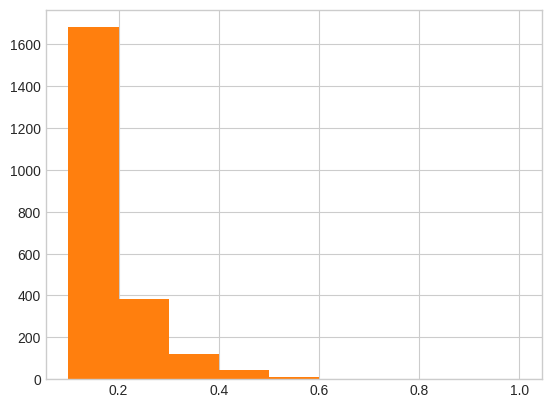

bicycle
false pos
(array([8.26612903e+00, 1.19623656e+00, 3.62903226e-01, 1.20967742e-01,
       4.03225806e-02, 6.72043011e-03, 6.72043011e-03, 0.00000000e+00,
       0.00000000e+00]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))
true pos
(array([2.55813953, 2.09302326, 2.17054264, 1.47286822, 0.69767442,
       0.69767442, 0.31007752, 0.        , 0.        ]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))


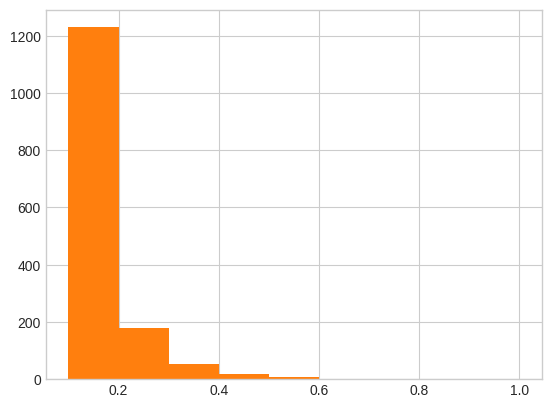

bus
false pos
(array([7.36280488, 1.875     , 0.48780488, 0.15243902, 0.09146341,
       0.0304878 , 0.        , 0.        , 0.        ]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))
true pos
(array([0.53763441, 0.32258065, 0.43010753, 0.32258065, 0.32258065,
       0.48387097, 0.53763441, 1.29032258, 5.75268817]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))


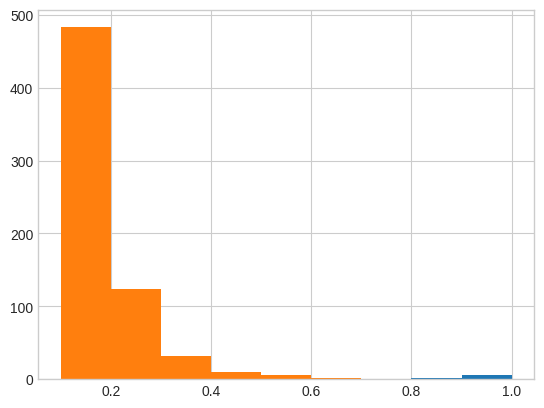

car
false pos
(array([7.08925221e+00, 1.58402573e+00, 6.59340659e-01, 3.26990083e-01,
       1.66175288e-01, 1.09890110e-01, 5.36049317e-02, 8.04073975e-03,
       2.68024658e-03]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))
true pos
(array([0.68713895, 0.64153238, 0.7236242 , 0.80267559, 0.81787777,
       1.15232593, 1.33779264, 2.35937975, 1.47765278]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))


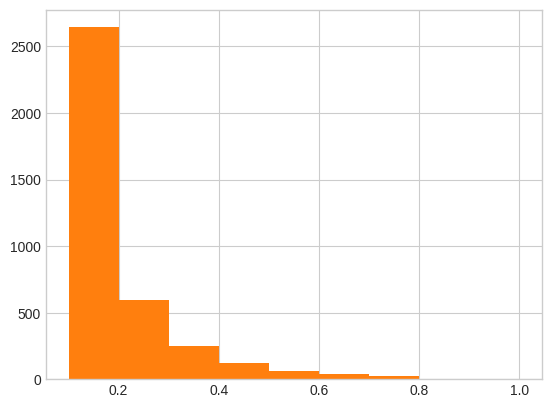

construction_vehicle
false pos
(array([8.35988754, 1.05904405, 0.29053421, 0.17806935, 0.0656045 ,
       0.03748828, 0.        , 0.        , 0.00937207]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))
true pos
(array([0.30534351, 0.53435115, 0.07633588, 0.        , 0.22900763,
       0.        , 0.38167939, 1.90839695, 6.5648855 ]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))


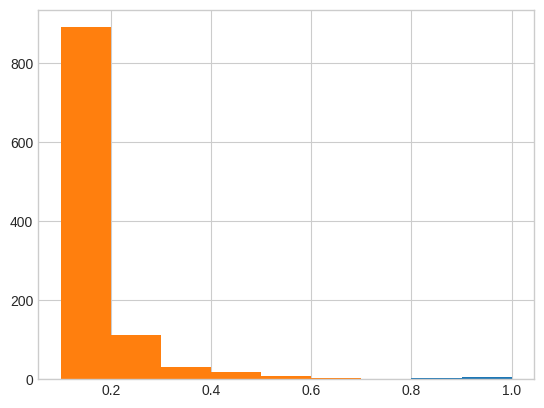

motorcycle
false pos
(array([8.36837679, 1.13540791, 0.28595458, 0.14297729, 0.04205214,
       0.        , 0.01682086, 0.        , 0.00841043]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))
true pos
(array([1.58273381, 1.07913669, 1.51079137, 1.36690647, 0.71942446,
       0.9352518 , 0.86330935, 0.86330935, 1.07913669]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))


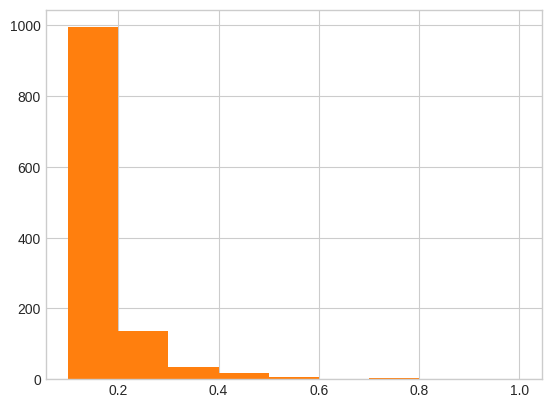

pedestrian
false pos
(array([7.57785467e+00, 1.75976273e+00, 4.59713297e-01, 1.63124073e-01,
       3.46020761e-02, 4.94315373e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))
true pos
(array([1.21169426, 2.53962663, 3.19830926, 1.81401902, 0.90524833,
       0.28178936, 0.04931314, 0.        , 0.        ]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))


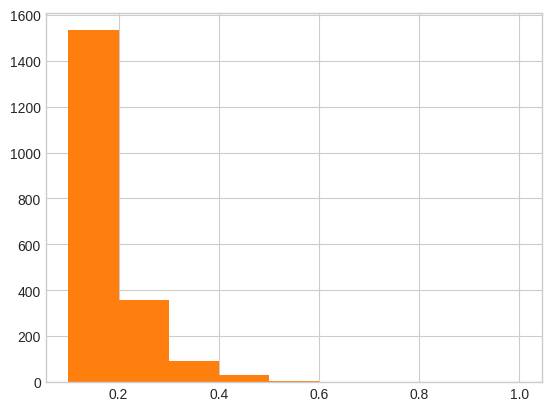

traffic_cone
false pos
(array([8.06430446e+00, 1.45013123e+00, 3.60892388e-01, 9.84251969e-02,
       1.96850394e-02, 0.00000000e+00, 6.56167979e-03, 0.00000000e+00,
       0.00000000e+00]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))
true pos
(array([2.19739292, 2.04841713, 2.09497207, 1.76908752, 0.90316574,
       0.55865922, 0.32588454, 0.10242086, 0.        ]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))


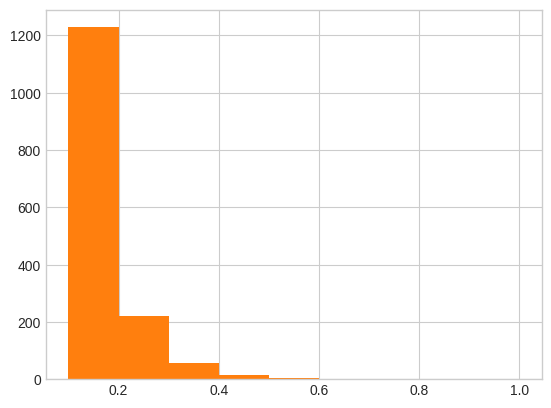

trailer
false pos
(array([8.31422792e+00, 1.30141605e+00, 2.29265003e-01, 1.01146325e-01,
       2.69723533e-02, 6.74308833e-03, 6.74308833e-03, 0.00000000e+00,
       1.34861767e-02]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))
true pos
(array([0.81632653, 0.6122449 , 0.6122449 , 0.        , 0.        ,
       0.        , 0.        , 0.40816327, 7.55102041]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))


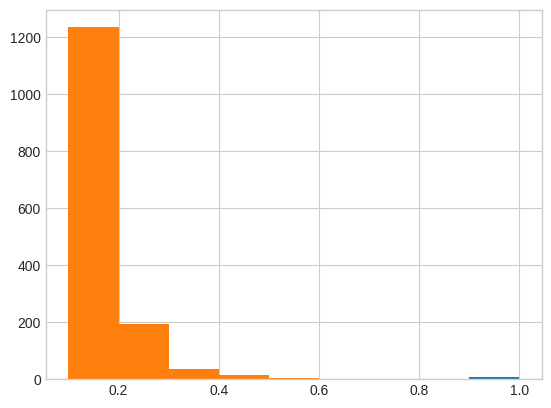

truck
false pos
(array([7.68275203, 1.40946011, 0.36311515, 0.20544673, 0.21500239,
       0.07166746, 0.04300048, 0.00955566, 0.        ]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))
true pos
(array([0.95505618, 0.64606742, 0.78651685, 0.6741573 , 0.78651685,
       1.01123596, 1.48876404, 1.37640449, 2.2752809 ]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))


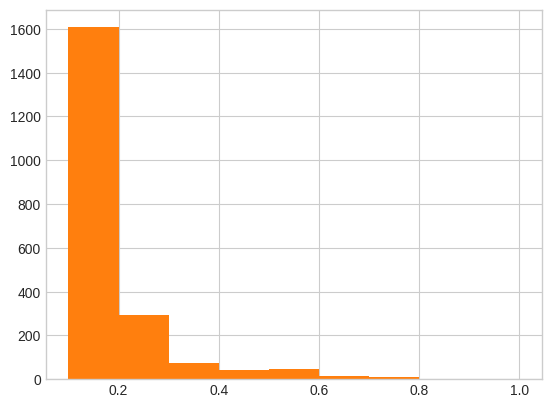

In [19]:
# Compute false det probabilities
min = 0.1
max = 1.
n_bins = 10
bins = np.linspace(min, max, n_bins, dtype=float)
print(bins)

det_classes = list(unmatched_det_df['det_lbl'].unique())
det_classes.sort()

print(det_classes)

for det in det_classes:
    m_df = match_df.loc[match_df['det_lbl']==det]
    u_df = unmatched_det_df.loc[unmatched_det_df['det_lbl']==det]
    print(det)
    
    unmatch_hist = np.histogram(u_df['det_conf'].astype(np.float64), bins=bins, density=True)
    match_hist = np.histogram(m_df['det_conf'].astype(np.float64), bins=bins, density=True)
    print("false pos")
    print(unmatch_hist)
    print("true pos")
    print(match_hist)
    
    plt.hist(m_df['det_conf'].astype(np.float64),bins=bins,density=True)
    plt.hist(u_df['det_conf'].astype(np.float64),bins=bins)
    
    plt.show()

# Compute sensor variance

In [23]:
det_classes = list(match_df['det_lbl'].unique())
det_classes.sort()

def euc_dist(row):
    return np.linalg.norm((row['ann_px'] - row['det_px'],row['ann_py'] - row['det_py']))

for det_cls in det_classes:
    print(det_cls)
    m_df = match_df.loc[match_df['det_lbl']==det_cls]

    # Compute sensor position variance
    delta_x = m_df['ann_px'] - m_df['det_px']
    delta_y = m_df['ann_py'] - m_df['det_py']
    delta_xy = m_df.apply(euc_dist,axis=1)
    delta_z = m_df['ann_pz'] - m_df['det_pz']
    
    # Compute sensor position variance
    delta_sx = m_df['ann_sx'] - m_df['det_sx']
    delta_sy = m_df['ann_sy'] - m_df['det_sy']
    delta_sz = m_df['ann_sz'] - m_df['det_sz']
    delta_yaw = m_df['ann_yaw'] - m_df['det_yaw']
    
    # Apply yaw correction
    def correct_yaw(yaw):
        if abs(yaw)>np.pi/2:
            return yaw - np.pi*np.sign(yaw)
        else:
            return yaw    
    delta_yaw = delta_yaw.apply(lambda yaw: correct_yaw(yaw))
    
    # plt.figure(1)
    # plt.subplot(311)
    # plt.hist(delta_x.astype(np.float64),100)
    # plt.subplot(312)
    # plt.hist(delta_y.astype(np.float64),100)
    # plt.subplot(313)
    # plt.hist(delta_xy.astype(np.float64),100)
    # plt.subplot(714)
    # plt.hist(delta_sx.astype(np.float64),100)
    # plt.subplot(715)
    # plt.hist(delta_sy.astype(np.float64),100)
    # plt.subplot(716)
    # plt.hist(delta_sz.astype(np.float64),100)
    # plt.subplot(717)
    # plt.hist(delta_yaw.astype(np.float64),100)
    # plt.show()
    
    print('pos')
    # print(np.mean(delta_x))
    # print(np.var(delta_x))
    # print(np.mean(delta_y))
    # print(np.var(delta_y))
    print((np.var(delta_x) + np.var(delta_y))/2)
    # print(np.mean(delta_z))
    print(np.var(delta_z))
    
    print()
    print('size')
    print(np.mean(delta_sx))
    print(np.var(delta_sx))
    print(np.mean(delta_sy))
    print(np.var(delta_sy))
    print(np.mean(delta_sz))
    print(np.var(delta_sz))
    print()
    print('yaw')
    print(np.mean(delta_yaw))
    print(np.var(delta_yaw))
    print()
    print()


barrier
pos
0.19549480211159082
0.01628104830024816

size
0.05828028103650998
0.07649809989957043
-0.06582138824411161
0.09765586852636558
-0.004994328456431816
0.01864021973289383

yaw
-0.00846686649038095
0.07899343440280769


bicycle
pos
0.04231392704591208
0.01688041976242154

size
0.04977371549975968
0.03112594824368436
-0.0059650814995285606
0.009807012284184654
-0.033629677584004945
0.01822546092813356

yaw
-0.009817199762612923
0.07498305964167162


bus
pos
0.23089963724717338
0.08786614893914946

size
-0.389630719605312
1.1320998402846387
0.01284549525476263
0.04339544362373047
-0.00807147020934727
0.0605678211887527

yaw
0.0024989805238367917
0.001475132706080469


car
pos
0.07472550636858336
0.02620064812087347

size
0.05178183935275026
0.0761677793115582
0.036138014284518766
0.01747576488403233
-0.015849575732536366
0.017710376117058047

yaw
0.019042447665546948
0.21465410949733477


construction_vehicle
pos
0.09060535643453502
0.04909401103547889

size
-0.3079231009592539


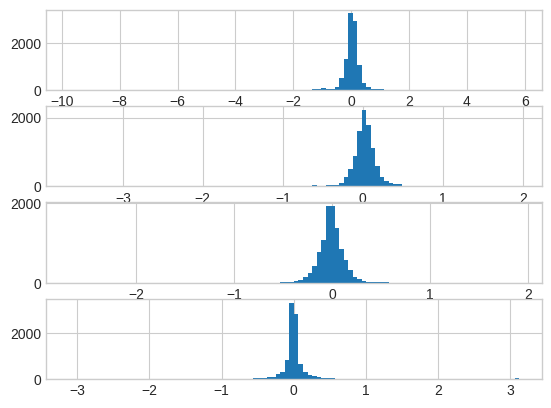

0.0245849312055087
0.1195705366994839
0.018359982218268414
0.04653887459823531
-0.007647847284687268
0.01974064942990225
0.009795673606743703
0.2471394166403764


In [46]:
# FIRST PASS - examine candidate matches

# Main loop - iterate through splits and mcaps
split = eval('nuscenes_splits.' + split_name)

for scene in split: # for scene in split
    print("Processing scene %s" % (scene))
    print("%s/%s%s/%s%s_0.mcap \n" % (mcap_dir, scene, lidar_det_string, scene, lidar_det_string))

    # Load bag
    storage_options = rosbag2_py.StorageOptions(
        uri="%s/%s%s/%s%s_0.mcap" % (mcap_dir, scene, lidar_det_string, scene, lidar_det_string),
        storage_id='mcap')
    converter_options = rosbag2_py.ConverterOptions('', '')
    reader.open(storage_options, converter_options)
    
    
    # Deal with type names
    topic_types = reader.get_all_topics_and_types()

    def typename(topic_name):
        for topic_type in topic_types:
            if topic_type.name == topic_name:
                return topic_type.type
        raise ValueError(f"topic {topic_name} not in bag")
 
    got_ann = False
    got_det = False
    matched_tracks = []
    matched_dets = []
    
    # Iterate through messages in .mcap
    while reader.has_next():
        
        topic, data, timestamp = reader.read_next()

        if topic==ann_topic:
            # self.get_logger().info("Topic: %s" % (topic))                  

            ann_msg_type = get_message(typename(topic))
            ann_msg = deserialize_message(data, ann_msg_type)
            
            got_ann = True
        
        if topic==det_topic:
            # self.get_logger().info("Topic: %s" % (topic))                  

            det_msg_type = get_message(typename(topic))
            det_msg = deserialize_message(data, det_msg_type)
            
            got_det = True
            
        if got_ann and got_det:
           
            # Compute cost matrix
            n_dets = len(det_msg.entities)
            n_anns = len(ann_msg.entities)
            
            cost_matrix = np.zeros((n_dets,n_anns))
            for ii,det in enumerate(det_msg.entities):
                for jj,trk in enumerate(ann_msg.entities):
                    
                    euc_dist = np.linalg.norm([det.cubes[0].pose.position.x - trk.cubes[0].pose.position.x,
                                           det.cubes[0].pose.position.y - trk.cubes[0].pose.position.y,
                                           det.cubes[0].pose.position.z - trk.cubes[0].pose.position.z])
                    
                    # IF this is a potential candidate match
                    if euc_dist < euc_thresh:
                        data_df = pd.DataFrame([[ann_msg.entities[jj].cubes[0].pose.position.x, 
                                                 ann_msg.entities[jj].cubes[0].pose.position.y,
                                                 ann_msg.entities[jj].cubes[0].pose.position.z,
                                                 ann_msg.entities[jj].cubes[0].size.x, 
                                                 ann_msg.entities[jj].cubes[0].size.y,
                                                 ann_msg.entities[jj].cubes[0].size.z,
                                                 ann_msg.entities[jj].metadata[0].value, # tracking_class_map[]
                                                 det_msg.entities[ii].cubes[0].pose.position.x,
                                                 det_msg.entities[ii].cubes[0].pose.position.y,
                                                 det_msg.entities[ii].cubes[0].pose.position.z,
                                                 det_msg.entities[ii].cubes[0].size.x,
                                                 det_msg.entities[ii].cubes[0].size.y,
                                                 det_msg.entities[ii].cubes[0].size.z,
                                                 det_msg.entities[ii].metadata[0].value,
                                                 det_msg.entities[ii].metadata[1].value]], columns=match_cols)

                        match_df = pd.concat([match_df,data_df], axis=0)
                        
                        matched_tracks.append(jj)
                        matched_dets.append(ii)
            

            # Handle mismatched annotations
            for i, trk in enumerate(ann_msg.entities):
                if i not in matched_tracks: # If track is unmatched, handle it as a missed detection
                
                    data_df = pd.DataFrame([[ann_msg.entities[i].cubes[0].pose.position.x, 
                                         ann_msg.entities[i].cubes[0].pose.position.y,
                                         ann_msg.entities[i].cubes[0].pose.position.z,
                                         ann_msg.entities[i].cubes[0].size.x, 
                                         ann_msg.entities[i].cubes[0].size.y,
                                         ann_msg.entities[i].cubes[0].size.z,
                                         ann_msg.entities[i].metadata[0].value]], 
                                           columns=unmatch_trk_cols)
                
                    unmatched_trk_df = pd.concat([unmatched_trk_df,data_df], axis=0)
            
            # Handle mismatched detections
            # If det is unmatched, handle it as a false detection
            for i, det in enumerate(det_msg.entities):
                if i not in matched_dets: # If track is unmatched, handle it as a missed detection
                    data_df = pd.DataFrame([[det_msg.entities[i].cubes[0].pose.position.x,
                                         det_msg.entities[i].cubes[0].pose.position.y,
                                         det_msg.entities[i].cubes[0].pose.position.z,
                                         det_msg.entities[i].cubes[0].size.x,
                                         det_msg.entities[i].cubes[0].size.y,
                                         det_msg.entities[i].cubes[0].size.z,
                                         det_msg.entities[i].metadata[0].value,
                                         det_msg.entities[i].metadata[1].value]], 
                                           columns=unmatch_det_cols)
                
                    unmatched_det_df = pd.concat([unmatched_det_df,data_df], axis=0)
            
            
            # Loop control
            got_ann = False
            got_det = False
            matched_tracks = []
            matched_dets = []        

Processing scene scene-0001
/home/jd/nuScenes/data/mcap/scene-0001-megvii/scene-0001-megvii_0.mcap 

Processing scene scene-0002
/home/jd/nuScenes/data/mcap/scene-0002-megvii/scene-0002-megvii_0.mcap 

Processing scene scene-0004
/home/jd/nuScenes/data/mcap/scene-0004-megvii/scene-0004-megvii_0.mcap 

Processing scene scene-0005
/home/jd/nuScenes/data/mcap/scene-0005-megvii/scene-0005-megvii_0.mcap 

Processing scene scene-0006
/home/jd/nuScenes/data/mcap/scene-0006-megvii/scene-0006-megvii_0.mcap 

Processing scene scene-0007
/home/jd/nuScenes/data/mcap/scene-0007-megvii/scene-0007-megvii_0.mcap 

Processing scene scene-0008
/home/jd/nuScenes/data/mcap/scene-0008-megvii/scene-0008-megvii_0.mcap 

Processing scene scene-0009
/home/jd/nuScenes/data/mcap/scene-0009-megvii/scene-0009-megvii_0.mcap 

Processing scene scene-0010
/home/jd/nuScenes/data/mcap/scene-0010-megvii/scene-0010-megvii_0.mcap 

Processing scene scene-0011
/home/jd/nuScenes/data/mcap/scene-0011-megvii/scene-0011-megvii

KeyboardInterrupt: 

# Analyze match candidates

In [39]:
# analyze the first pass - 
print(match_df.shape)
print(unmatched_det_df.shape)
print(unmatched_trk_df.shape)

(24003, 15)
(12882, 8)
(3155, 7)


## p(label_candidate|class)

## Compute confusion matrix p(label|class)

In [40]:
# compute discrete class distribution of p(label_candidates|class)
# Form confusion matrix / class-det table
det_classes = list(match_df['det_lbl'].unique())
det_classes.sort()
# det_classes.insert(0,'missed_det')
ann_classes = list(match_df['ann_lbl'].unique())
ann_classes.sort()
# ann_classes.insert(0,'false_det')

print(ann_classes)
print(det_classes)

raw_conf_df = pd.DataFrame(np.zeros((len(ann_classes),len(det_classes))), columns = det_classes, index=ann_classes,dtype=np.float64)

for index,row in match_df.iterrows():
    raw_conf_df[row['det_lbl']][row['ann_lbl']] +=1
    
# Treat unmatched dets as false det classs
# for index,row in unmatched_det_df.iterrows():
#     raw_conf_df[row['det_lbl']]['false_det'] +=1

# Treat unmatched tracks as missed dets
# for index,row in unmatched_trk_df.iterrows():
#     raw_conf_df['missed_det'][row['ann_lbl']] +=1

print(raw_conf_df)


['human.pedestrian.adult', 'human.pedestrian.construction_worker', 'human.pedestrian.personal_mobility', 'human.pedestrian.police_officer', 'movable_object.barrier', 'movable_object.debris', 'movable_object.pushable_pullable', 'movable_object.trafficcone', 'vehicle.bicycle', 'vehicle.bus.bendy', 'vehicle.bus.rigid', 'vehicle.car', 'vehicle.construction', 'vehicle.motorcycle', 'vehicle.trailer', 'vehicle.truck']
['barrier', 'bicycle', 'bus', 'car', 'construction_vehicle', 'motorcycle', 'pedestrian', 'traffic_cone', 'trailer', 'truck']
                                      barrier  bicycle    bus     car  \
human.pedestrian.adult                  185.0    269.0   10.0    42.0   
human.pedestrian.construction_worker    303.0     23.0    0.0     7.0   
human.pedestrian.personal_mobility        0.0     11.0    0.0     0.0   
human.pedestrian.police_officer           0.0      0.0    0.0     0.0   
movable_object.barrier                 4497.0     81.0    3.0    78.0   
movable_object.debris 

In [41]:
p_label_class_df = raw_conf_df.div(raw_conf_df.sum(axis=1),axis=0)
print(p_label_class_df)

                                       barrier   bicycle       bus       car  \
human.pedestrian.adult                0.025677  0.037335  0.001388  0.005829   
human.pedestrian.construction_worker  0.443631  0.033675  0.000000  0.010249   
human.pedestrian.personal_mobility    0.000000  0.282051  0.000000  0.000000   
human.pedestrian.police_officer       0.000000  0.000000  0.000000  0.000000   
movable_object.barrier                0.791725  0.014261  0.000528  0.013732   
movable_object.debris                 0.000000  0.333333  0.000000  0.000000   
movable_object.pushable_pullable      0.000000  0.186992  0.000000  0.008130   
movable_object.trafficcone            0.209426  0.017011  0.000000  0.035973   
vehicle.bicycle                       0.163934  0.415984  0.000000  0.036885   
vehicle.bus.bendy                     0.000000  0.000000  0.709091  0.036364   
vehicle.bus.rigid                     0.004484  0.000000  0.659193  0.089686   
vehicle.car                           0.

## p(pos_z|pos_x)

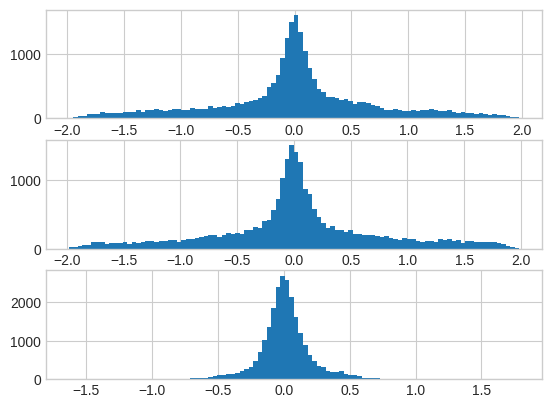

0.002624280832065991
0.49218989789630435
0.020628265121265518
0.5287559327750198
0.010083883428197986
0.04159826069849194


In [7]:
# Compute sensor position variance
delta_x = match_df['ann_px'] - match_df['det_px']
delta_y = match_df['ann_py'] - match_df['det_py']
delta_z = match_df['ann_pz'] - match_df['det_pz']


plt.figure(1)
plt.subplot(311)
plt.hist(delta_x.astype(np.float64),100)
plt.subplot(312)
plt.hist(delta_y.astype(np.float64),100)
plt.subplot(313)
plt.hist(delta_z.astype(np.float64),100)
plt.show()

print(np.mean(delta_x))
print(np.var(delta_x))
print(np.mean(delta_y))
print(np.var(delta_y))
print(np.mean(delta_z))
print(np.var(delta_z))

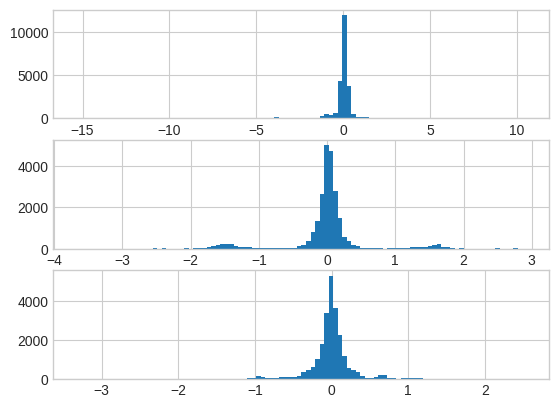

-0.05431638457956093
1.087373253252593
-0.011076922825950889
0.3197079380069313
-0.015352861276404168
0.10313720817741763


In [8]:
# Compute sensor size variance
delta_sx = match_df['ann_sx'] - match_df['det_sx']
delta_sy = match_df['ann_sy'] - match_df['det_sy']
delta_sz = match_df['ann_sz'] - match_df['det_sz']

plt.figure(2)
plt.subplot(311)
plt.hist(delta_sx.astype(np.float64),100)
plt.subplot(312)
plt.hist(delta_sy.astype(np.float64),100)
plt.subplot(313)
plt.hist(delta_sz.astype(np.float64),100)
plt.show()

print(np.mean(delta_sx))
print(np.var(delta_sx))
print(np.mean(delta_sy))
print(np.var(delta_sy))
print(np.mean(delta_sz))
print(np.var(delta_sz))

# Compute false det likelihood p(match|conf)

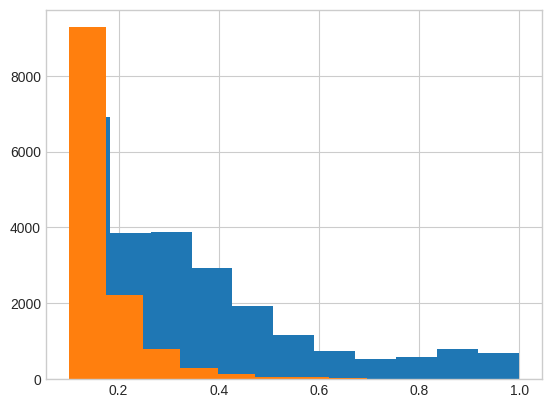

(array([10314,  1797,   484,   177,    69,    26,    11,     3,     1]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))
(array([7832, 4657, 4264, 2588, 1419,  845,  633,  914,  851]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))


In [27]:
# Examine distributions of match candidates vs. non-matches
plt.hist(match_df['det_conf'].astype(np.float64),11)
plt.hist(unmatched_det_df['det_conf'].astype(np.float64),11)
plt.show()

mu_unmatch = np.mean(unmatched_det_df['det_conf'].astype(np.float64))
sigma_unmatch = np.var(unmatched_det_df['det_conf'].astype(np.float64))
mu_match = np.mean(match_df['det_conf'].astype(np.float64))
sigma_match = np.var(match_df['det_conf'].astype(np.float64))

unmatch_hist = np.histogram(unmatched_det_df['det_conf'].astype(np.float64), bins=bins)
match_hist = np.histogram(match_df['det_conf'].astype(np.float64), bins=bins)
print(unmatch_hist)
print(match_hist)


[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
['barrier', 'bicycle', 'bus', 'car', 'construction_vehicle', 'motorcycle', 'pedestrian', 'traffic_cone', 'trailer', 'truck']
barrier
(array([907, 210,  74,  28,   5,   1,   1,   0,   0]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))
(array([2423, 1415, 1210,  611,  221,   76,    8,    2,    0]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))


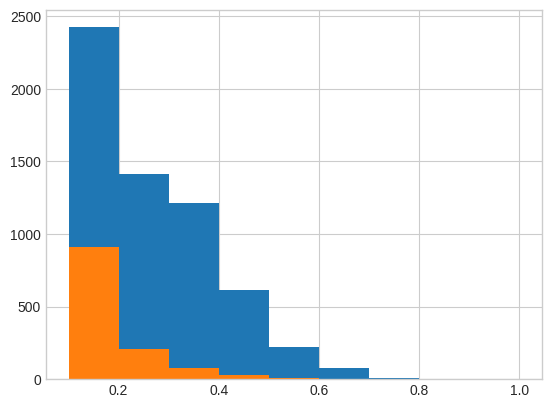

bicycle
(array([989, 114,  32,   9,   3,   0,   0,   0,   0]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))
(array([435, 140,  85,  45,  17,  20,   6,   0,   0]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))


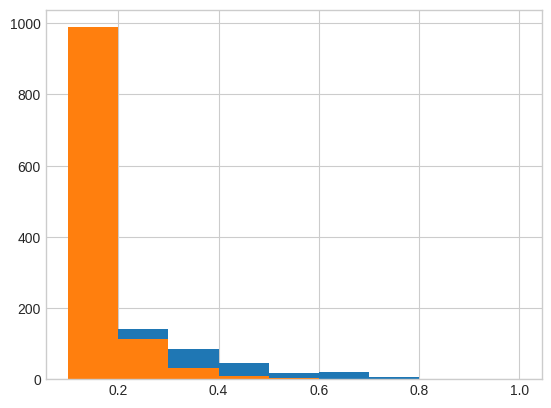

bus
(array([436,  75,  25,   9,   3,   2,   0,   0,   0]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))
(array([ 59,  54,  15,   7,  10,   9,  10,  24, 107]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))


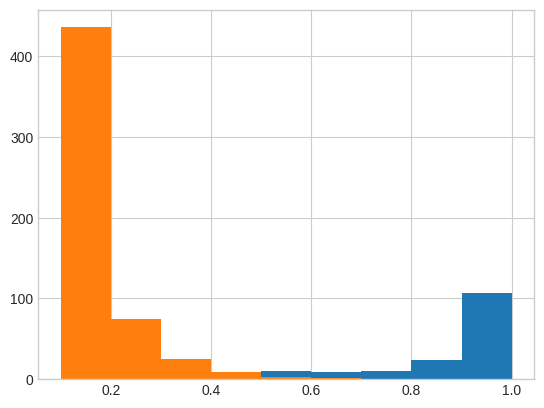

car
(array([2332,  481,  157,   59,   36,   14,    8,    3,    0]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))
(array([606, 339, 335, 337, 303, 408, 456, 784, 505]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))


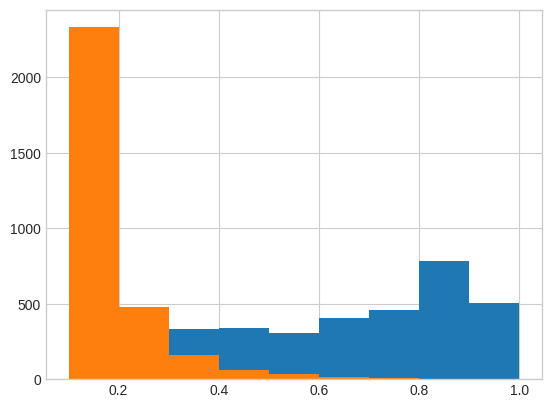

construction_vehicle
(array([787,  99,  26,  17,   7,   3,   0,   0,   0]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))
(array([150,  30,   6,   2,   3,   1,   5,  27, 104]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))


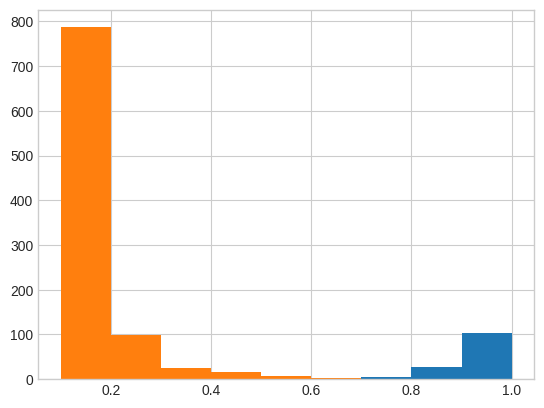

motorcycle
(array([840, 111,  25,  13,   3,   0,   2,   0,   1]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))
(array([211,  40,  31,  23,  12,  14,  12,  12,  15]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))


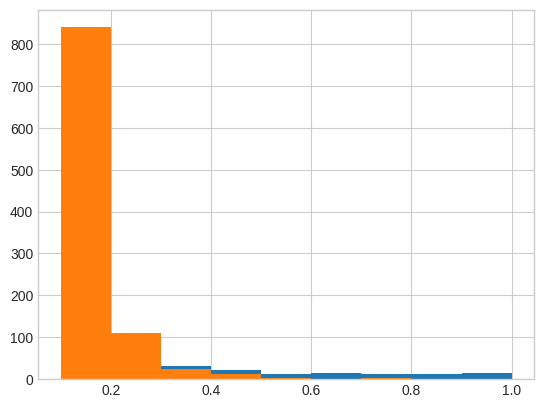

pedestrian
(array([1047,  218,   54,   10,    4,    1,    0,    0,    0]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))
(array([1648, 1814, 2016, 1101,  573,  163,   26,    0,    0]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))


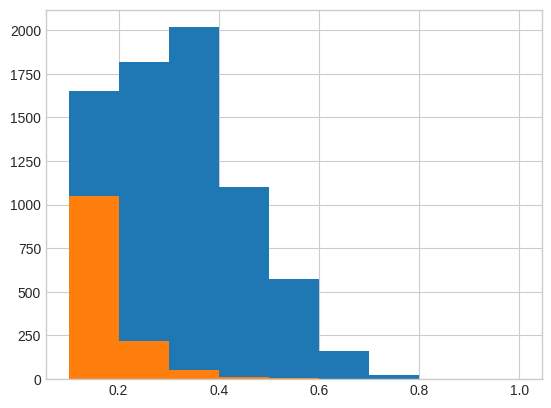

traffic_cone
(array([805, 138,  37,   8,   0,   0,   0,   0,   0]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))
(array([1542,  659,  478,  404,  211,  106,   44,   12,    0]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))


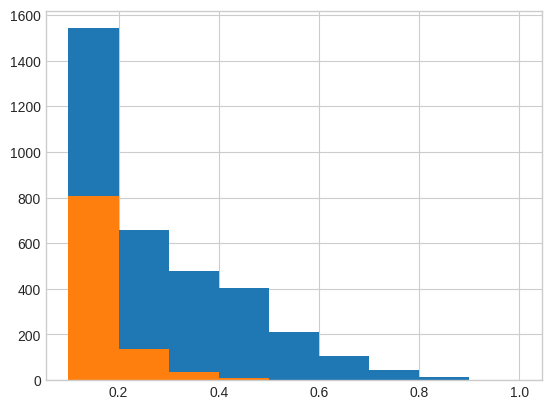

trailer
(array([1162,  184,   30,   15,    3,    1,    0,    0,    0]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))
(array([88, 15,  7,  0,  1,  0,  1,  2, 39]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))


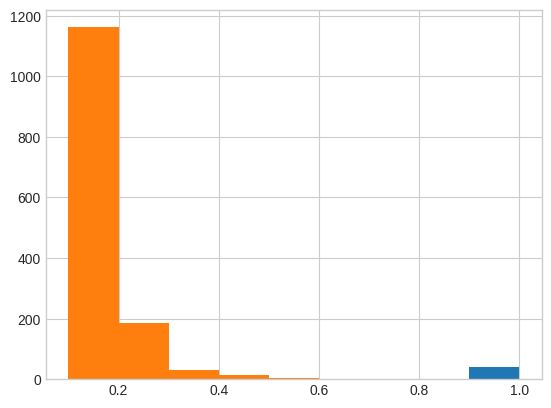

truck
(array([1009,  167,   24,    9,    5,    4,    0,    0,    0]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))
(array([670, 151,  81,  58,  68,  48,  65,  51,  81]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))


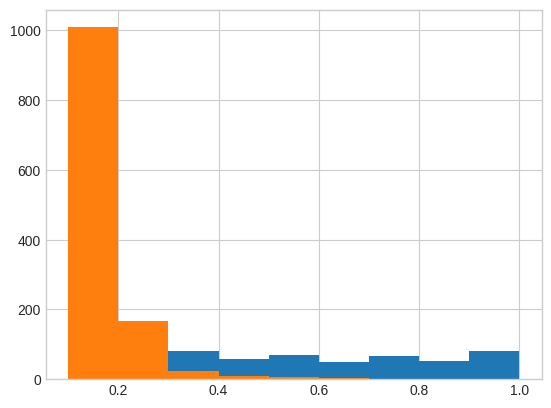

In [26]:
min = 0.1
max = 1.
n_bins = 10
bins = np.linspace(min, max, n_bins, dtype=float)
print(bins)

det_classes = list(unmatched_det_df['det_lbl'].unique())
det_classes.sort()

print(det_classes)

for det in det_classes:
    m_df = match_df.loc[match_df['det_lbl']==det]
    u_df = unmatched_det_df.loc[unmatched_det_df['det_lbl']==det]
    print(det)
    
    unmatch_hist = np.histogram(u_df['det_conf'].astype(np.float64), bins=bins)
    match_hist = np.histogram(m_df['det_conf'].astype(np.float64), bins=bins)
    print(unmatch_hist)
    print(match_hist)
    
    plt.hist(m_df['det_conf'].astype(np.float64),bins=bins)
    plt.hist(u_df['det_conf'].astype(np.float64),bins=bins)
    plt.show()


In [25]:



unmatch_hist = np.histogram(unmatched_det_df['det_conf'].astype(np.float64), bins=bins)
match_hist = np.histogram(match_df['det_conf'].astype(np.float64), bins=bins)

print(unmatch_hist)
print(match_hist)


conf = .96
unmatch_ind = np.searchsorted( unmatch_hist[1], conf, side='right')
match_ind = np.searchsorted(match_hist[1], conf, side='right')

print(unmatch_ind)
print(match_ind)

print(unmatch_hist[0][unmatch_ind-1])
print(match_hist[0][match_ind-1])

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
(array([10314,  1797,   484,   177,    69,    26,    11,     3,     1]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))
(array([7832, 4657, 4264, 2588, 1419,  845,  633,  914,  851]), array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))
9
9
1
851


In [6]:
print(match_df.shape)
print(unmatched_det_df.shape)
print(unmatched_trk_df.shape)

(11608, 15)
(15917, 8)
(2416, 7)


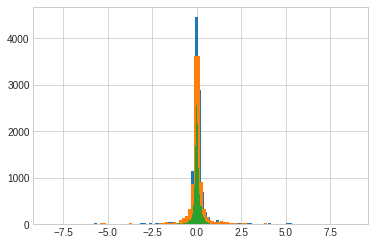

0.02434939557586046
1.4392160083787156
-0.027295775430214077
1.320857552431175
-0.0029345892153881466
0.07043345574085993


In [7]:
delta_x = match_df['ann_px'] - match_df['det_px']
delta_y = match_df['ann_py'] - match_df['det_py']
delta_z = match_df['ann_pz'] - match_df['det_pz']

plt.hist(delta_x.astype(np.float64),100)
plt.hist(delta_y.astype(np.float64),100)
plt.hist(delta_z.astype(np.float64),100)
plt.show()

print(np.mean(delta_x))
print(np.var(delta_x))
print(np.mean(delta_y))
print(np.var(delta_y))
print(np.mean(delta_z))
print(np.var(delta_z))

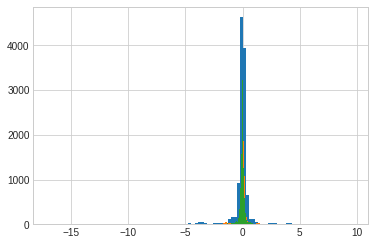

In [8]:
delta_sx = match_df['ann_sx'] - match_df['det_sx']
delta_sy = match_df['ann_sy'] - match_df['det_sy']
delta_sz = match_df['ann_sz'] - match_df['det_sz']

plt.hist(delta_sx.astype(np.float64),100)
plt.hist(delta_sy.astype(np.float64),100)
plt.hist(delta_sz.astype(np.float64),100)
plt.show()

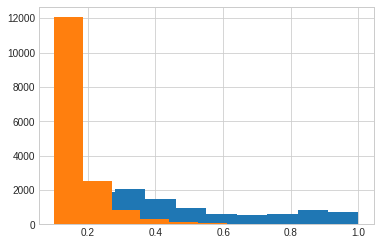

0.16515561904396148
0.006610592494992953
0.4369561585702315
0.06404195386146624
0.0066324876037182475
0.047494622262219725
Discrete Prior
 P( 0 ):
 Choice(0) 
 0 Leaf 0.12253541
 1 Leaf 0.87746459




In [10]:
# plt.hist(delta_x,100)
# plt.hist(delta_y,100)
plt.hist(match_df['det_conf'].astype(np.float64))
plt.hist(unmatched_det_df['det_conf'].astype(np.float64))
plt.show()

mu_unmatch = np.mean(unmatched_det_df['det_conf'].astype(np.float64))
sigma_unmatch = np.var(unmatched_det_df['det_conf'].astype(np.float64))
mu_match = np.mean(match_df['det_conf'].astype(np.float64))
sigma_match = np.var(match_df['det_conf'].astype(np.float64))

print(mu_unmatch)
print(sigma_unmatch)
print(mu_match)
print(sigma_match)

x = .2
likelihood_match = np.exp(-(x - mu_match)**2/(2*sigma_match**2))/(np.sqrt(2*np.pi)*sigma_match)
likelihood_unmatch = np.exp(-(x)**2/(2*sigma_match**2))/(np.sqrt(2*np.pi)*sigma_match)
print(likelihood_match)
print(likelihood_unmatch)

p_track = gtsam.DiscreteDistribution([0,2], [likelihood_match, likelihood_unmatch])
print(p_track)

In [11]:
# Form confusion matrix / class-det table
det_classes = list(match_df['det_lbl'].unique())
det_classes.sort()
det_classes.insert(0,'missed_det')
ann_classes = list(match_df['ann_lbl'].unique())
ann_classes.sort()
ann_classes.insert(0,'false_det')

print(ann_classes)
print(det_classes)

['false_det', 'bicycle', 'bus', 'car', 'motorcycle', 'pedestrian', 'trailer', 'truck', 'void_ignore']
['missed_det', 'barrier', 'bicycle', 'bus', 'car', 'construction_vehicle', 'motorcycle', 'pedestrian', 'traffic_cone', 'trailer', 'truck']


In [18]:
raw_conf_df = pd.DataFrame(np.zeros((len(ann_classes),len(det_classes))), columns = det_classes, index=ann_classes,dtype=np.float64)

for index,row in match_df.iterrows():
    raw_conf_df[row['det_lbl']][row['ann_lbl']] +=1
    
# Treat unmatched dets as false det classs
for index,row in unmatched_det_df.iterrows():
    raw_conf_df[row['det_lbl']]['false_det'] +=1

# Treat unmatched tracks as missed dets
for index,row in unmatched_trk_df.iterrows():
    raw_conf_df['missed_det'][row['ann_lbl']] +=1

print(raw_conf_df)

             missed_det  barrier  bicycle    bus     car  \
false_det           0.0   1978.0   1348.0  618.0  3350.0   
bicycle            17.0      9.0    112.0    1.0    12.0   
bus               144.0      0.0      0.0  176.0     8.0   
car              1215.0     36.0     15.0   24.0  3403.0   
motorcycle         29.0      4.0     35.0    1.0     5.0   
pedestrian        482.0     68.0     69.0    9.0    54.0   
trailer             9.0      0.0      0.0    0.0     0.0   
truck             104.0      6.0      0.0    5.0   103.0   
void_ignore       416.0   1978.0     38.0    8.0    85.0   

             construction_vehicle  motorcycle  pedestrian  traffic_cone  \
false_det                   979.0      1099.0      1856.0        1442.0   
bicycle                       0.0         7.0        23.0           0.0   
bus                           4.0         0.0         0.0           0.0   
car                          27.0        45.0        20.0          13.0   
motorcycle              

In [19]:
missed_det_df = raw_conf_df.div(raw_conf_df.sum(axis=1),axis=0)
print(missed_det_df)

             missed_det   barrier   bicycle       bus       car  \
false_det      0.000000  0.124270  0.084689  0.038826  0.210467   
bicycle        0.089005  0.047120  0.586387  0.005236  0.062827   
bus            0.390244  0.000000  0.000000  0.476965  0.021680   
car            0.240546  0.007127  0.002970  0.004752  0.673728   
motorcycle     0.136792  0.018868  0.165094  0.004717  0.023585   
pedestrian     0.131802  0.018594  0.018868  0.002461  0.014766   
trailer        0.150000  0.000000  0.000000  0.000000  0.000000   
truck          0.198095  0.011429  0.000000  0.009524  0.196190   
void_ignore    0.105077  0.499621  0.009598  0.002021  0.021470   

             construction_vehicle  motorcycle  pedestrian  traffic_cone  \
false_det                0.061507    0.069046    0.116605      0.090595   
bicycle                  0.000000    0.036649    0.120419      0.000000   
bus                      0.010840    0.000000    0.000000      0.000000   
car                      0.00

In [21]:
false_det_df = raw_conf_df.div(raw_conf_df.sum(axis=0),axis=1)
print(false_det_df)

             missed_det   barrier   bicycle       bus       car  \
false_det      0.000000  0.484923  0.833643  0.733967  0.477208   
bicycle        0.007036  0.002206  0.069264  0.001188  0.001709   
bus            0.059603  0.000000  0.000000  0.209026  0.001140   
car            0.502897  0.008826  0.009276  0.028504  0.484758   
motorcycle     0.012003  0.000981  0.021645  0.001188  0.000712   
pedestrian     0.199503  0.016671  0.042672  0.010689  0.007692   
trailer        0.003725  0.000000  0.000000  0.000000  0.000000   
truck          0.043046  0.001471  0.000000  0.005938  0.014672   
void_ignore    0.172185  0.484923  0.023500  0.009501  0.012108   

             construction_vehicle  motorcycle  pedestrian  traffic_cone  \
false_det                0.817195    0.827560    0.381736      0.555042   
bicycle                  0.000000    0.005271    0.004731      0.000000   
bus                      0.003339    0.000000    0.000000      0.000000   
car                      0.02

# Now, test out using existence probability dist instead of false_det class

In [2]:
prob_class_det = conf_df.data

NameError: name 'conf_df' is not defined